In [1]:
from jax import config

config.update("jax_enable_x64", True)

import jax
from jax import jit
import jax.numpy as jnp
from jaxoplanet.starry import Ylm, Surface

from harmonix.harmonix import Harmonix
from harmonix.solution import solution_vector, transform_to_zernike
import numpy as np
from scipy.special import j1

import matplotlib.pyplot as plt

# Comparing the Harmonix model against a brute-force 2D discrete Fourier transform:


In this notebook, I will create a simple simulation of an interferometric observation of a star. I will instantiate a Harmonix model for the star and compute the visibilities and closure phases analytically. Then, I will compare that to the traditional way of computing the visibilities and closure phases using a discrete Fourier transform, ensuring they match. This notebook will be rewritten as a unit test. 

## Simulating UV coordinates:

In [2]:
u, v = np.linspace(-500,500,64), np.linspace(-500,500,64)
wavel = 2e-6 # m

uu, vv = np.meshgrid(np.linspace(-500,500,64),np.linspace(-500,500,64))
uvgrid = np.vstack((uu.flatten(),vv.flatten())).T

## Airy disk case:

Let's first test the base case: An l=0 spherical harmonic map, which should reduce to an Airy function in visibilities:

In [3]:
mas2rad = jnp.pi / 180.0 / 3600.0/ 1000.0
radius = 1.0 # mas

def airy(w, lam, diam):
    '''Airy function for a circular aperture, evaluated on baselines uv (m) with diameter diam (mas) at wavelength lam (m)'''
    
    r = w/lam

    d = diam*mas2rad

    return 2 * j1(jnp.pi * r * d) / (jnp.pi * r * d)

# Define the spherical harmonic map
ylm = Ylm.from_dense(jnp.array([1.0]))
star = Surface(y=ylm, inc=0., obl=0, period=1.0)
# Time doesn't matter for a uniform map
t = 0.0
cvis = Harmonix(star).model(radius*mas2rad*2*jnp.pi*uvgrid[:,0]/wavel, radius*mas2rad*2*jnp.pi*uvgrid[:,1]/wavel, t)

Text(0.5, 0, 'Baseline')

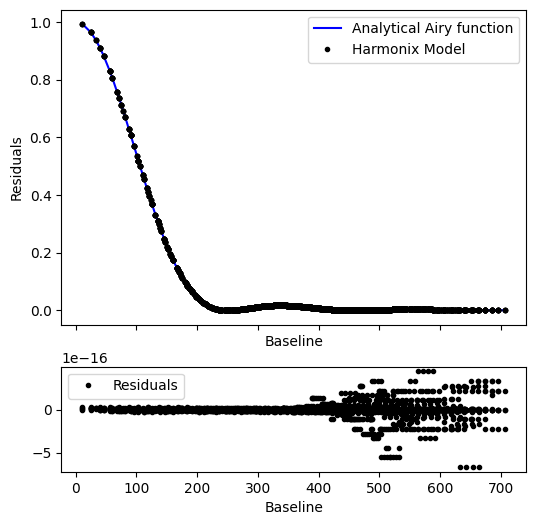

In [4]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6,6), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
wgrid = np.sqrt(uvgrid[:,0]**2 + uvgrid[:,1]**2)
ft_anal = airy(np.sort(wgrid), wavel,2*radius)
v2_anal, phase_anal = jnp.abs(ft_anal)**2, jnp.angle(ft_anal)
ax1.plot(np.sort(wgrid),v2_anal, 'b-', label='Analytical Airy function')

v2, phase = jnp.abs(cvis)**2, jnp.angle(cvis)
ax1.plot(wgrid,v2,'k.', label='Harmonix Model')
ax1.set_ylabel(r"$V^2$")
plt.xlabel(r"Baseline")
ax1.legend()
inds = np.argsort(wgrid)
ax2.plot(wgrid,v2[inds]-v2_anal, 'k.', label='Residuals')
ax2.legend()
ax1.set_ylabel(r"Residuals")
ax1.set_xlabel(r"Baseline")

## Rendering `jaxoplanet.starry.Surface`:

Now, let's render the intensity on a `jaxoplanet.starry.Surface` object and evaluate the discrete Fourier transform and compare to Harmonix

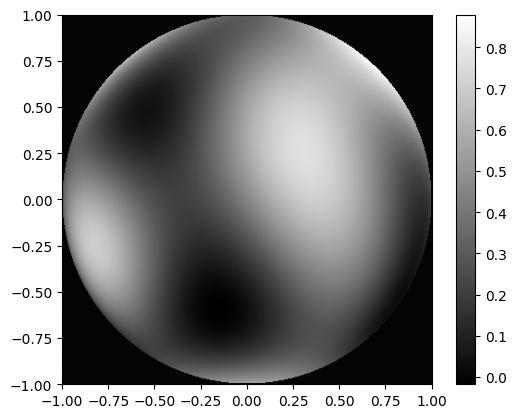

In [5]:
from jaxoplanet.starry.utils import ortho_grid

@jit
def compute_DFTM1(x,y,uv,wavel):
    '''Compute a direct Fourier transform matrix, from coordinates x and y (milliarcsec) to uv (metres) at a given wavelength wavel.'''

    # Convert to radians
    x = x * jnp.pi / 180.0 / 3600.0/ 1000.0
    y = y * jnp.pi / 180.0 / 3600.0/ 1000.0

    # get uv in nondimensional units
    uv = uv / wavel

    # Compute the matrix
    dftm = jnp.exp(-2j* jnp.pi* (jnp.outer(uv[:,0],x)+jnp.outer(uv[:,1],y)))

    return dftm

@jit
def apply_DFTM1(image,dftm):
    '''Apply a direct Fourier transform matrix to an image.'''
    image /= image.sum()
    return jnp.dot(dftm,image.ravel())

# Define the spherical harmonic map
np.random.seed(35)  # For reproducibility

coeffs = jnp.array([1.00,  0.22,  0.19,  0.11,  0.11,  0.07,  -0.11, 0.00,  -0.05, 
     0.12,  0.16,  -0.05, 0.06,  0.12,  0.05,  -0.10, 0.04,  -0.02, 
     0.01,  0.10,  0.08,  0.15,  0.13,  -0.11, -0.07, -0.14, 0.06, 
     -0.19, -0.02, 0.07,  -0.02, 0.07,  -0.01, -0.07, 0.04,  0.00])

                    
ylm = Ylm.from_dense(coeffs)
star = Surface(y=ylm, inc=jnp.radians(90.), obl=0.0, period=1.0)

res = 400
x, y = jnp.meshgrid(jnp.linspace(-1, 1, res), jnp.linspace(-1, 1, res))
image = star.render(res=res,theta=jnp.radians(0.))
image = jnp.nan_to_num(image, nan=0.0)
plt.imshow(image, origin='lower', cmap='gray', extent=(-1, 1, -1, 1))
plt.colorbar()

In [6]:
dftm = compute_DFTM1(x, y, uvgrid, wavel)
cvis_dftm = apply_DFTM1(image, dftm)

In [7]:
cvis = Harmonix(star).model(radius*mas2rad*2*jnp.pi*uvgrid[:,0]/wavel, radius*mas2rad*2*jnp.pi*uvgrid[:,1]/wavel, 0.0)

Text(0.5, 0, 'Baseline')

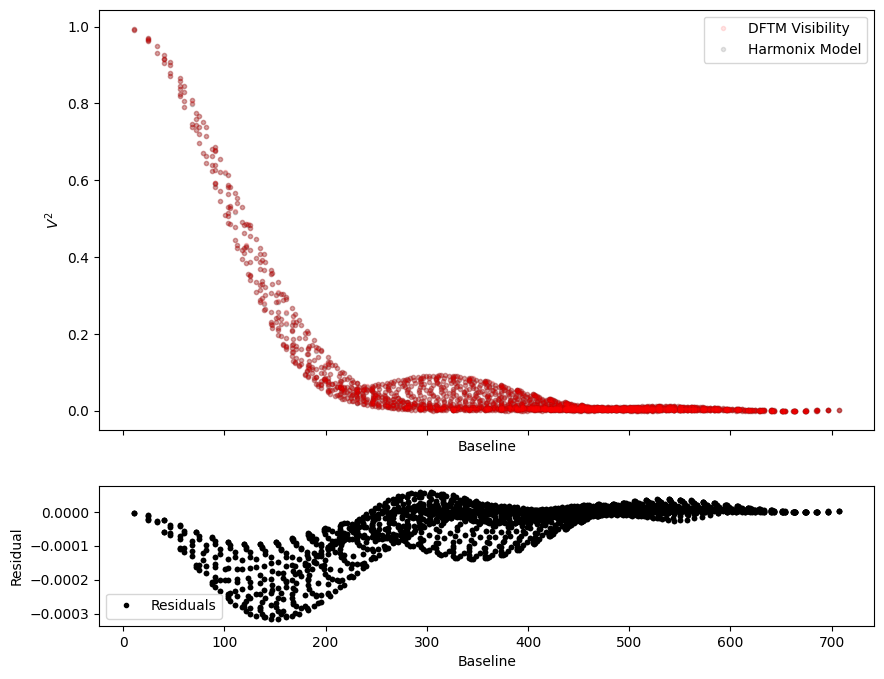

In [8]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
v2_dftm, phase_dftm = jnp.abs(cvis_dftm)**2, jnp.angle(cvis_dftm)

ax1.plot(wgrid,v2_dftm, 'r.', label='DFTM Visibility',zorder=3,alpha=0.1)

v2, phase = jnp.abs(cvis)**2, jnp.angle(cvis)
ax1.plot(wgrid,v2,'k.', label='Harmonix Model',alpha=0.1)

#v2_scipy, phase_scipy = jnp.abs(scipy_test)**2, jnp.angle(scipy_test)
#v2_new, phase_new = jnp.abs(cvis2)**2, jnp.angle(cvis2)
#ax1.plot(wgrid,v2_new,'b.', label='Scipy Model',alpha=0.1)
ax1.set_ylabel(r"$V^2$")
plt.xlabel(r"Baseline")
ax1.legend()
ax2.plot(wgrid,v2-v2_dftm, 'k.', label='Residuals')
#ax2.plot(wgrid,v2_new-v2_dftm, 'b.', label='Neg')
ax2.legend()
ax2.set_ylabel(r"Residual")
ax1.set_xlabel(r"Baseline")

(-0.05, 0.05)

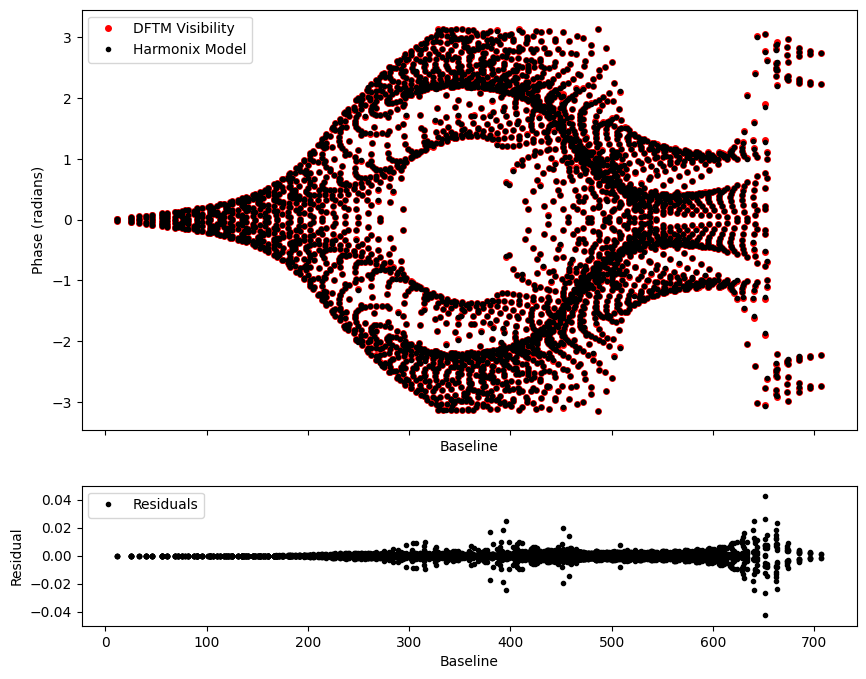

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax1.plot(wgrid,phase_dftm, 'ro', label='DFTM Visibility', ms=4)

ax1.plot(wgrid,phase,'k.', label='Harmonix Model')

#v2_scipy, phase_scipy = jnp.abs(scipy_test)**2, jnp.angle(scipy_test)
#ax1.plot(wgrid,phase_new,'b.', label='Scipy Model',alpha=0.1)
ax1.set_ylabel(r"Phase (radians)")
plt.xlabel(r"Baseline")
ax1.legend()
ax2.plot(wgrid,phase-phase_dftm, 'k.', label='Residuals')
#ax2.plot(wgrid,phase_new-phase_dftm, 'b.', label='Neg')
ax2.legend()
ax2.set_ylabel(r"Residual")
ax1.set_xlabel(r"Baseline")
ax2.set_ylim(-0.05,0.05)